### The Pipeline

So far in this series, we learned about Tensors, and we've learned all about PyTorch neural networks. We are now ready to begin the training process.

1. Prepare the data
2. Build the model
3. __Train the model__ 
4. Analyze the model's results

Training is essentially gradient descent: we calculate the gradient of the loss, and use this to update the weights so that the resulting loss is closer the the minima. 

### Training

During training, we get a __batch__ and pass it forward through the network. Once the output is obtained, we compare the predicted output to the actual labels, and once we know how close the predicted values are from the actual labels, we tweak the weights inside the network in such a way that the values the network predicts move closer to the true values (labels). All of this is for a single batch, and we repeat this process for every batch until we have covered every sample in our training set. 

After we've completed this process for all of the batches and passed over every sample in our training set, we say that an __epoch__ is complete. During the entire training process, we do as many epochs as necessary to reach our desired level of accuracy. 

__Training a neural net:__
1. Get batch from the training set.
2. Pass batch to network.
3. Calculate the __loss__ (difference between the predicted values and the true values).
4. Calculate the gradient of the loss function w.r.t the network's weights.
5. Update the weights using the gradients to reduce the loss.
6. Repeat steps 1-5 until one epoch is completed.
7. Repeat steps 1-6 for as many epochs required to reach the minimum loss.

We know how to do steps 1 and 2. The loss is specified depending on the problem. We use backpropagation and an optimization algorithm to perform step 4 and 5. Steps 6 and 7 are just standard Python loops (the training loop).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self, channels=1): # default grayscale
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=6, kernel_size=5) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120) # ((28-5+1)/2 -5 +1)/2 = 4
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        # (1) input layer
        t = t
        
        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t) # activation_function='relu' in tf.keras      
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t) # activation_funcion='relu' in tf.keras
        
        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        
        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1) # first index is batch
        return t

In [3]:
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


In [4]:
import torchvision
import torchvision.transforms as transform

train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    download=True,
    transform=transform.ToTensor())

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
batch = next(iter(train_loader)) # get one batch
images, labels = batch

# initialize a network
network = Network() 

In [5]:
def get_num_correct(preds, labels):
    return (preds.argmax(dim=1) == labels).sum()

#### Cross entropy loss

`F.cross_entropy` combines __negative log-loss with softmax and averages the result__. Thus we comment out above the softmax activation. Here we have a batch size of 2. Thus to compare absolute lossess for different batch sizes one must multiply by the batch size. 

In [39]:
F.cross_entropy(torch.tensor([[3, 6, 2], [1, 1, 2]]).float(), torch.tensor([2, 1]))

tensor(2.8087)

In [42]:
import numpy as np
softmax = lambda a: np.exp(a) / np.exp(a).sum()

(-np.log(softmax(np.array([3,6,2])))[2] + -np.log(softmax(np.array([1,1,2])))[1])/2 # averages

2.8086643088447403

#### Backpropagation and Gradient Descent

In [13]:
import torch.optim as optim
optimizer = optim.Adam(network.parameters(), lr=0.01) # optimizer has access to network parameters

In [6]:
network.conv1.weight.grad is None

True

In [14]:
preds = network(images)
loss = F.cross_entropy(preds, labels) 
print('loss: ', loss) 
print('no. correct:', get_num_correct(preds, labels)) # out of 100

loss:  tensor(2.3068, grad_fn=<NllLossBackward>)
no. correct: tensor(12)


In [15]:
loss.backward() # backprop, looks at definition of loss and crawls backward into the network
network.conv1.weight.grad.shape # gradients updated after one pass of backprop

torch.Size([6, 1, 5, 5])

In [16]:
optimizer.step() # based on our new loss gradient values, we update weights accdg to Adam to minimize loss.

In [17]:
preds = network(images) # run new predictions
loss = F.cross_entropy(preds, labels) 
print('loss after backprop: ', loss, 'no. correct:', get_num_correct(preds, labels))

loss after backprop:  tensor(2.2887, grad_fn=<NllLossBackward>) no. correct: tensor(14)


The correct predictions have increased after one step of gradient descent!

### Training one batch

Collect everything in one place:

In [18]:
# compile the neural net
network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.01)


# loss
loss = F.cross_entropy(network(images), labels)
print("Step 0:")
print(loss.item())
print(get_num_correct(network(images), labels))

# backprop
loss.backward()  # update gradients
optimizer.step() # update weights using gradients to minimize loss

# recalculating loss based on new weights
loss = F.cross_entropy(network(images), labels)
print("\nStep 1:")
print(loss.item())
print(get_num_correct(network(images), labels))

Step 0:
2.3104944229125977
tensor(11)

Step 1:
2.2894699573516846
tensor(11)


### Training a single epoch

In [19]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100) 

network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.01)

total_loss = 0
total_correct = 0
for batch in train_loader:
    images, labels = batch 

    preds = network(images) 
    loss = F.cross_entropy(preds, labels) 

    optimizer.zero_grad() 
    loss.backward()  # calculate gradients
    optimizer.step() # update weights using gradients using adam

    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)
    
print(
    "epoch:", 0, 
    "total_correct:", total_correct, 
    "loss:", total_loss
)

epoch: 0 total_correct: tensor(46885) loss: 346.6361614763737


Setting the gradients to zero in line 14 is necessary because `loss.backward()` _adds_ the calculated gradients instead of assigning them. 

In [20]:
optimizer.zero_grad()

In [21]:
network.conv1.weight.grad.sum()

tensor(0.)

### Training with multiple epochs

In [22]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)

network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.01)

for epoch in range(10):    
    total_loss = 0
    total_correct = 0
    
    for batch in train_loader:    
        images, labels = batch 
        preds = network(images)
        loss = F.cross_entropy(preds, labels) # check that loss tensor has a gradient attribute
                                              # so that line 17 makes sense
        optimizer.zero_grad() # set all gradients to zero
        loss.backward() # calculate gradient
        optimizer.step() # update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

epoch 0 total_correct: tensor(45570) loss: 380.7395526468754
epoch 1 total_correct: tensor(50782) loss: 251.97550985217094
epoch 2 total_correct: tensor(51535) loss: 229.5160759538412
epoch 3 total_correct: tensor(51801) loss: 220.17312617599964
epoch 4 total_correct: tensor(52229) loss: 211.77114780247211
epoch 5 total_correct: tensor(52350) loss: 208.3045560270548
epoch 6 total_correct: tensor(52407) loss: 206.49326403439045
epoch 7 total_correct: tensor(52563) loss: 201.06376388669014
epoch 8 total_correct: tensor(52860) loss: 194.65639048814774
epoch 9 total_correct: tensor(52807) loss: 196.51216650009155


In [25]:
52807/60000 # train accuracy

0.8801166666666667

### 26 CNN Training with Code Example - Neural Network 

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

print(torch.__version__)
print(torchvision.__version__)

class Network(nn.Module):
    def __init__(self, channels=1): # default grayscale
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=6, kernel_size=5) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120) # ((28-5+1)/2 -5 +1)/2 = 4
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        # (1) input layer
        t = t
        
        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t) # activation_function='relu' in tf.keras      
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t) # activation_funcion='relu' in tf.keras
        
        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        
        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1) # first index is batch
        return t

2.5.1+cu124
0.20.1+cu124


In [7]:
import torchvision
import torchvision.transforms as transform

train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    download=True,
    transform=transform.ToTensor())

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
batch = next(iter(train_loader)) # get one batch
images, labels = batch

#### Calculating the Loss

In [8]:
network = Network()

preds = network(images)
loss = F.cross_entropy(preds, labels) 
                                      # so that line 17 makes sense
loss.item()

2.301067352294922

#### Calculating the Gradients

In [9]:
print(network.conv1.weight.grad)

None


In [10]:
loss.backward()

In [12]:
network.conv1.weight.grad.shape

torch.Size([6, 1, 5, 5])

In [14]:
import torch.optim as optim
optimizer = optim.Adam(network.parameters(), lr=0.01)

In [24]:
loss.item(),get_num_correct(preds, labels)

(2.2816882133483887, tensor(15))

In [49]:
optimizer.step()

In [50]:
preds = network(images)
loss = F.cross_entropy(preds, labels)
loss.item(), get_num_correct(preds, labels)

(23.248939514160156, tensor(15))

#### Train Using a Single Batch

In [ ]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

batch = next(iter(train_loader)) # get one batch
images, labels = batch 

preds = network(images)
loss = F.cross_entropy(preds, labels) # check that loss tensor has a gradient attribute
                                      # so that line 17 makes sense
loss.backward() # calculate gradient
optimizer.step() # update Weights

#-------------
print('loss1:', loss.item())
preds = network(images)
loss = F.cross_entropy(preds, labels)
print('loss2:', loss.item())


loss1: 2.3032708168029785
loss2: 2.2862601280212402


### 27 CNN Traning Loop Explained

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transform

print(torch.__version__)
print(torchvision.__version__)


class Network(nn.Module):
    def __init__(self, channels=1): # default grayscale
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=6, kernel_size=5) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120) # ((28-5+1)/2 -5 +1)/2 = 4
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, (2, 2), stride=2)

        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, (2, 2), stride=2)

        t = t.reshape(-1, 12*4*4)
        t = F.relu(self.fc1(t))

        t = F.relu(self.fc2(t))

        t = self.out(t)
        
        return t

def get_num_correct(preds, labels):
    return (preds.argmax(dim=1) == labels).sum().item()


train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    download=True,
    transform=transform.Compose([
        transform.ToTensor()
    ]))


# ------------------
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100) 
network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.01)

total_loss = 0
total_correct = 0
for batch in train_loader:
    images, labels = batch 

    preds = network(images) 
    loss = F.cross_entropy(preds, labels) 

    optimizer.zero_grad() 
    loss.backward()  # calculate gradients
    optimizer.step() # update weights using gradients using adam

    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)
    
print(
    "epoch:", 0, 
    "total_correct:", total_correct, 
    "loss:", total_loss
)



2.5.1+cu124
0.20.1+cu124
epoch: 0 total_correct: 46811 loss: 344.3063161224127


In [2]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)

network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.01)

for epoch in range(10):    
    total_loss = 0
    total_correct = 0
    
    for batch in train_loader:    
        images, labels = batch 
        preds = network(images)
        loss = F.cross_entropy(preds, labels) # check that loss tensor has a gradient attribute
                                              # so that line 17 makes sense
        optimizer.zero_grad() # set all gradients to zero
        loss.backward() # calculate gradient
        optimizer.step() # update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )



epoch 0 total_correct: 47915 loss: 323.7321205884218
epoch 1 total_correct: 51724 loss: 225.10179708898067
epoch 2 total_correct: 52319 loss: 208.45353515446186
epoch 3 total_correct: 52640 loss: 199.4921850040555
epoch 4 total_correct: 52851 loss: 195.29109853506088
epoch 5 total_correct: 52995 loss: 189.51475496590137
epoch 6 total_correct: 53130 loss: 185.72132973372936
epoch 7 total_correct: 53299 loss: 182.47346794605255
epoch 8 total_correct: 53261 loss: 182.5880050510168
epoch 9 total_correct: 53442 loss: 178.57270574569702


### 28 CNN Confustion Matrix with PyTorch

#### Analyzing CNN Results - Building and Plotting a Confusion Matrix

In [3]:
len(train_set), len(train_set.targets)

(60000, 60000)

#### Getting predictionas for the entire training set

In [4]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

In [5]:
prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)

train_preds = get_all_preds(network, prediction_loader)

In [6]:
train_preds.shape

torch.Size([60000, 10])

In [7]:
print(train_preds.requires_grad)

False


In [8]:
train_preds.grad_fn

#### Building a confusion matrix

In [9]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [10]:
train_preds.argmax(dim=1)

tensor([9, 0, 0,  ..., 3, 0, 5])

In [11]:
stacked = torch.stack((
    train_set.targets, 
    train_preds.argmax(dim=1)
    ,), dim=1
)

In [12]:
stacked.shape

torch.Size([60000, 2])

In [13]:
stacked[0].tolist()

[9, 9]

In [14]:

cmt = torch.zeros(10, 10, dtype=torch.int32)

for p in stacked:
    tl, pl = p.tolist()
    cmt[tl][pl] += 1

cmt


tensor([[5617,    5,   99,   76,    4,    2,  151,    0,   46,    0],
        [  17, 5901,    0,   54,    1,    2,    9,    0,   16,    0],
        [  77,    1, 5162,   43,  432,    1,  253,    0,   31,    0],
        [ 233,   86,   29, 5402,   87,    1,  137,    0,   23,    2],
        [  11,    3,  488,  274, 4754,    0,  416,    0,   54,    0],
        [   0,    0,    1,    2,    0, 5766,    0,  172,   12,   47],
        [1501,    5,  693,  110,  323,    0, 3261,    0,  107,    0],
        [   0,    0,    1,    0,    0,   11,    0, 5819,    5,  164],
        [  27,    0,   13,   10,    7,    8,   10,    1, 5923,    1],
        [   0,    0,    1,    0,    0,   28,    0,  144,    2, 5825]],
       dtype=torch.int32)

#### Plotting a confusion Matrix

Confusion matrix, without normalization
tensor([[5617,    5,   99,   76,    4,    2,  151,    0,   46,    0],
        [  17, 5901,    0,   54,    1,    2,    9,    0,   16,    0],
        [  77,    1, 5162,   43,  432,    1,  253,    0,   31,    0],
        [ 233,   86,   29, 5402,   87,    1,  137,    0,   23,    2],
        [  11,    3,  488,  274, 4754,    0,  416,    0,   54,    0],
        [   0,    0,    1,    2,    0, 5766,    0,  172,   12,   47],
        [1501,    5,  693,  110,  323,    0, 3261,    0,  107,    0],
        [   0,    0,    1,    0,    0,   11,    0, 5819,    5,  164],
        [  27,    0,   13,   10,    7,    8,   10,    1, 5923,    1],
        [   0,    0,    1,    0,    0,   28,    0,  144,    2, 5825]],
       dtype=torch.int32)


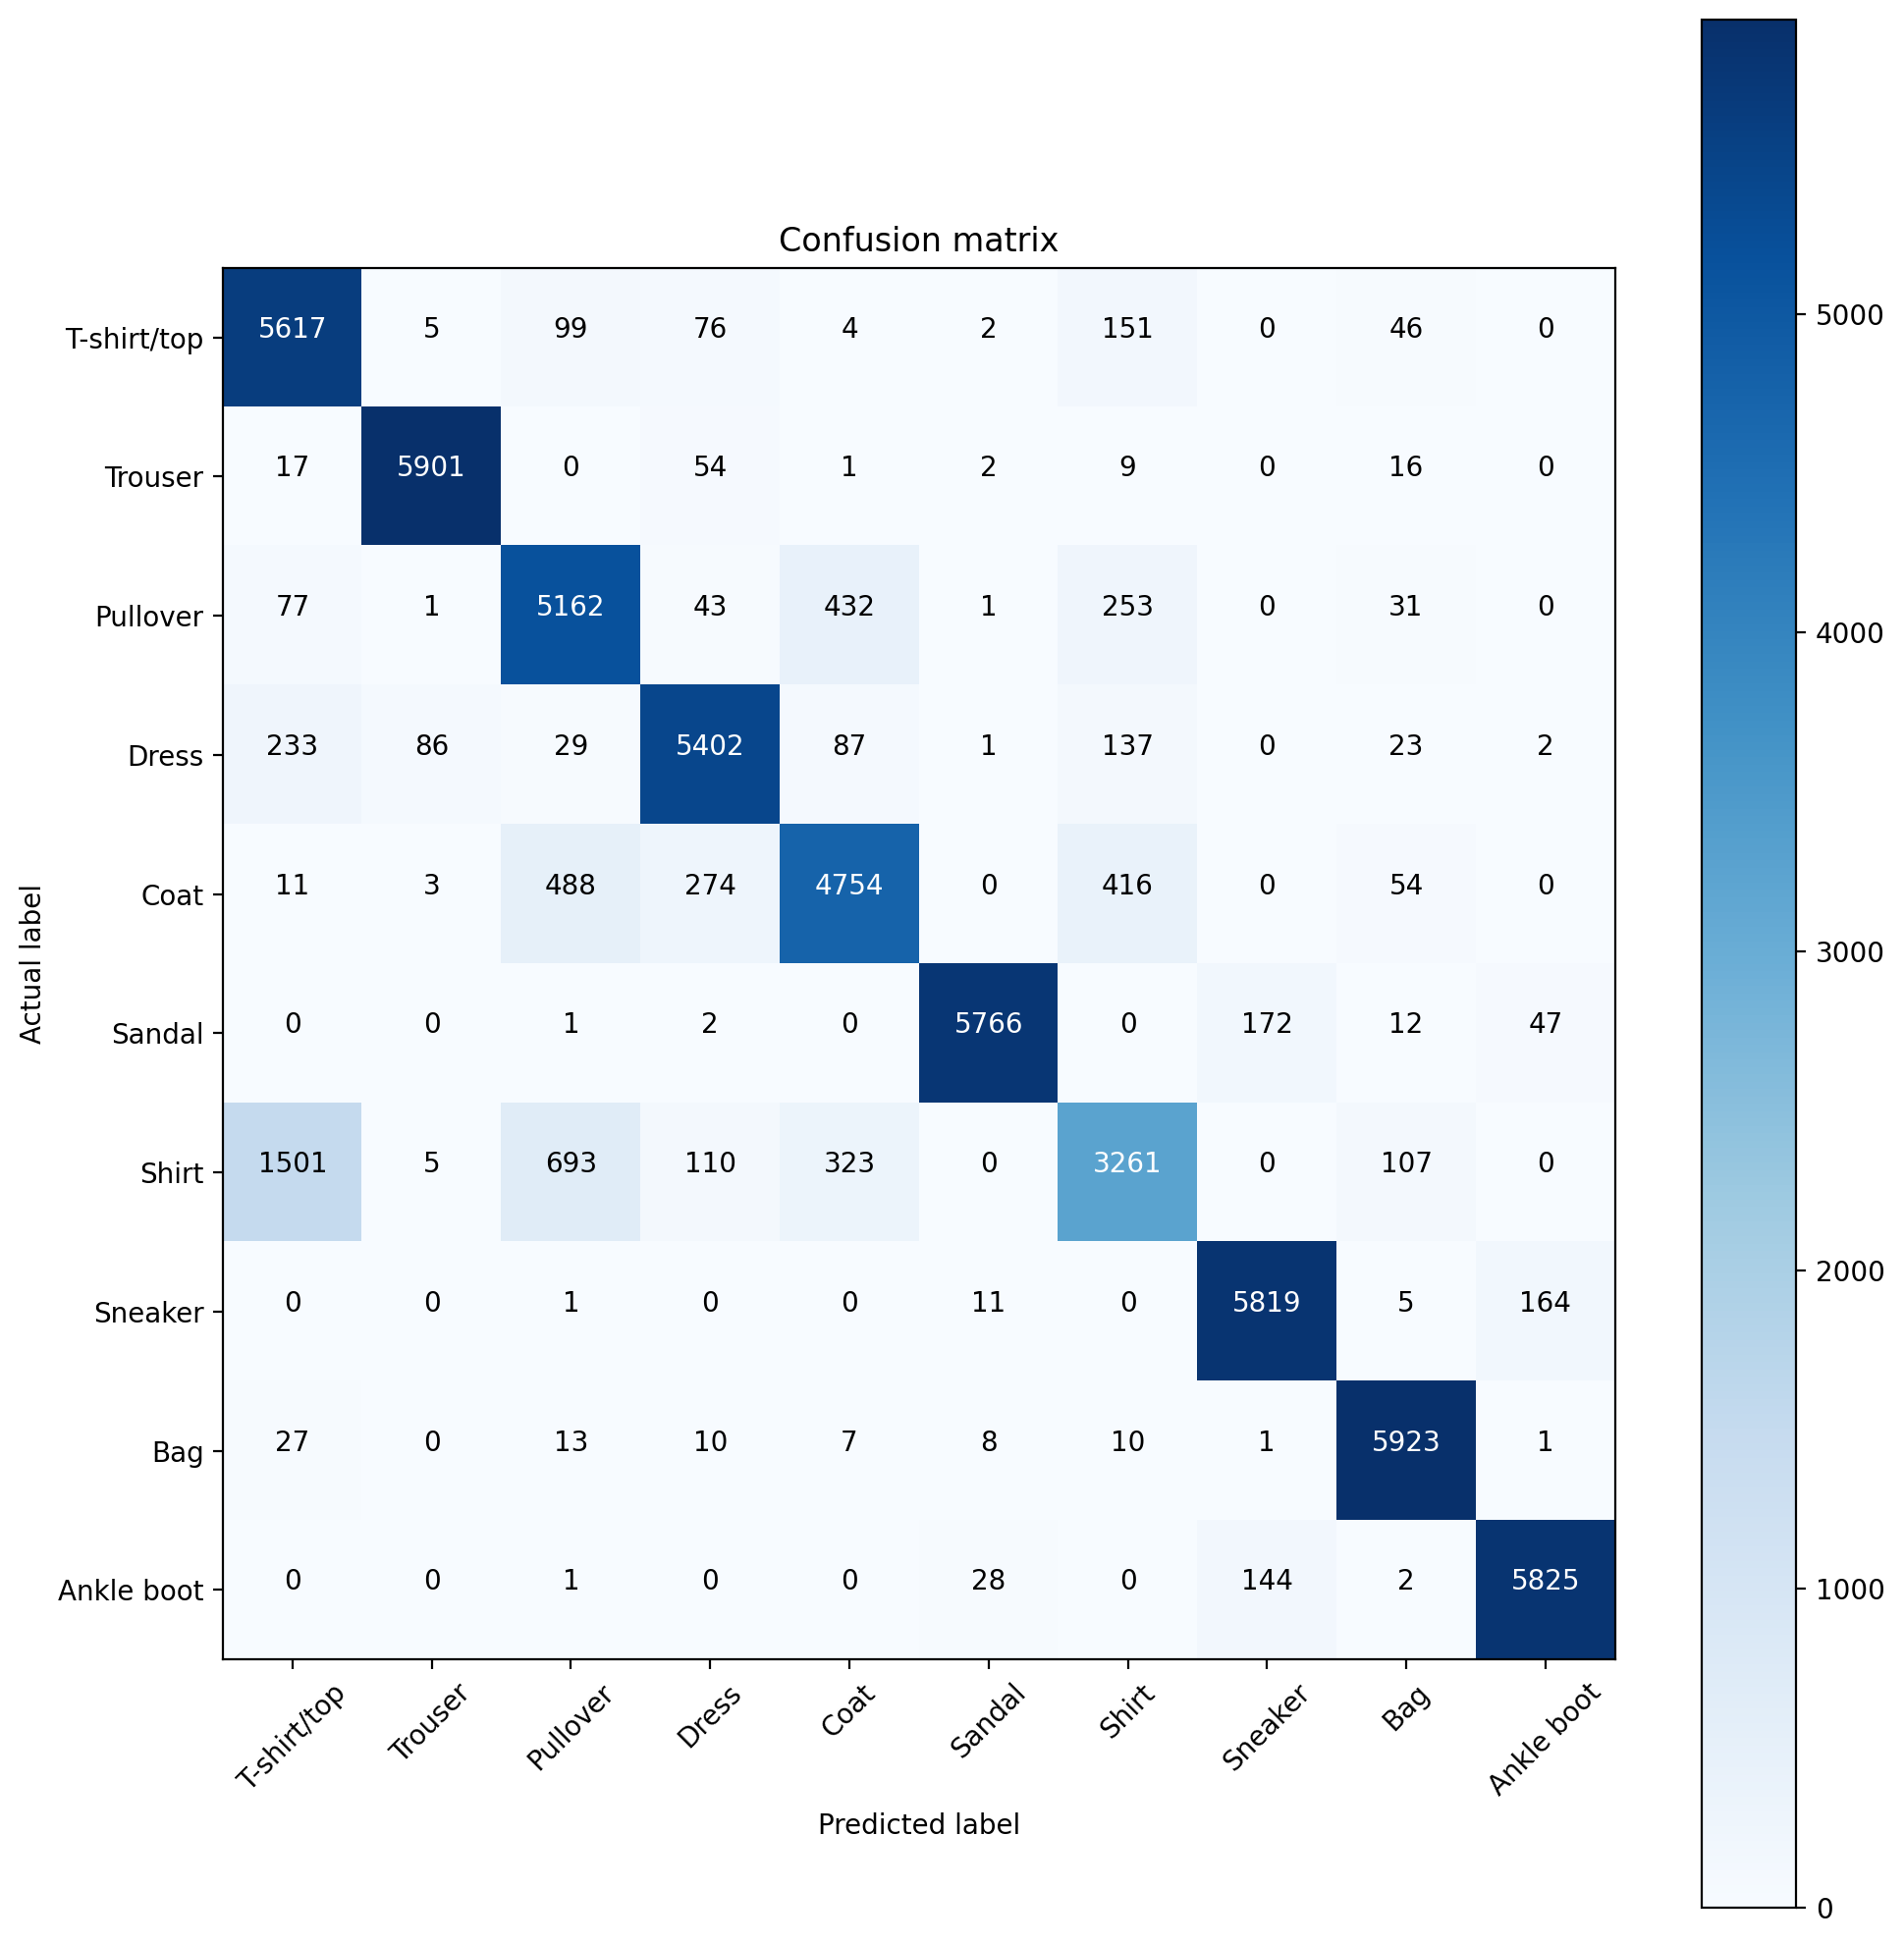

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_confusion_matrix(cm, classes, 
                          normalize=False, 
                          title='Confusion matrix', 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # print the cm
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    # plot the cm
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd' # float or int
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black") # color of text

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    

names = (
    'T-shirt/top'
    ,'Trouser'
    ,'Pullover'
    ,'Dress'
    ,'Coat'
    ,'Sandal'
    ,'Shirt'
    ,'Sneaker'
    ,'Bag'
    ,'Ankle boot'
)
plt.figure(figsize=(10,10), dpi=200)
plot_confusion_matrix(cmt, names)


In [18]:

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
# pip install scikit-learn

In [19]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[5617,    5,   99,   76,    4,    2,  151,    0,   46,    0],
       [  17, 5901,    0,   54,    1,    2,    9,    0,   16,    0],
       [  77,    1, 5162,   43,  432,    1,  253,    0,   31,    0],
       [ 233,   86,   29, 5402,   87,    1,  137,    0,   23,    2],
       [  11,    3,  488,  274, 4754,    0,  416,    0,   54,    0],
       [   0,    0,    1,    2,    0, 5766,    0,  172,   12,   47],
       [1501,    5,  693,  110,  323,    0, 3261,    0,  107,    0],
       [   0,    0,    1,    0,    0,   11,    0, 5819,    5,  164],
       [  27,    0,   13,   10,    7,    8,   10,    1, 5923,    1],
       [   0,    0,    1,    0,    0,   28,    0,  144,    2, 5825]])

Confusion matrix, without normalization
tensor([[5617,    5,   99,   76,    4,    2,  151,    0,   46,    0],
        [  17, 5901,    0,   54,    1,    2,    9,    0,   16,    0],
        [  77,    1, 5162,   43,  432,    1,  253,    0,   31,    0],
        [ 233,   86,   29, 5402,   87,    1,  137,    0,   23,    2],
        [  11,    3,  488,  274, 4754,    0,  416,    0,   54,    0],
        [   0,    0,    1,    2,    0, 5766,    0,  172,   12,   47],
        [1501,    5,  693,  110,  323,    0, 3261,    0,  107,    0],
        [   0,    0,    1,    0,    0,   11,    0, 5819,    5,  164],
        [  27,    0,   13,   10,    7,    8,   10,    1, 5923,    1],
        [   0,    0,    1,    0,    0,   28,    0,  144,    2, 5825]],
       dtype=torch.int32)


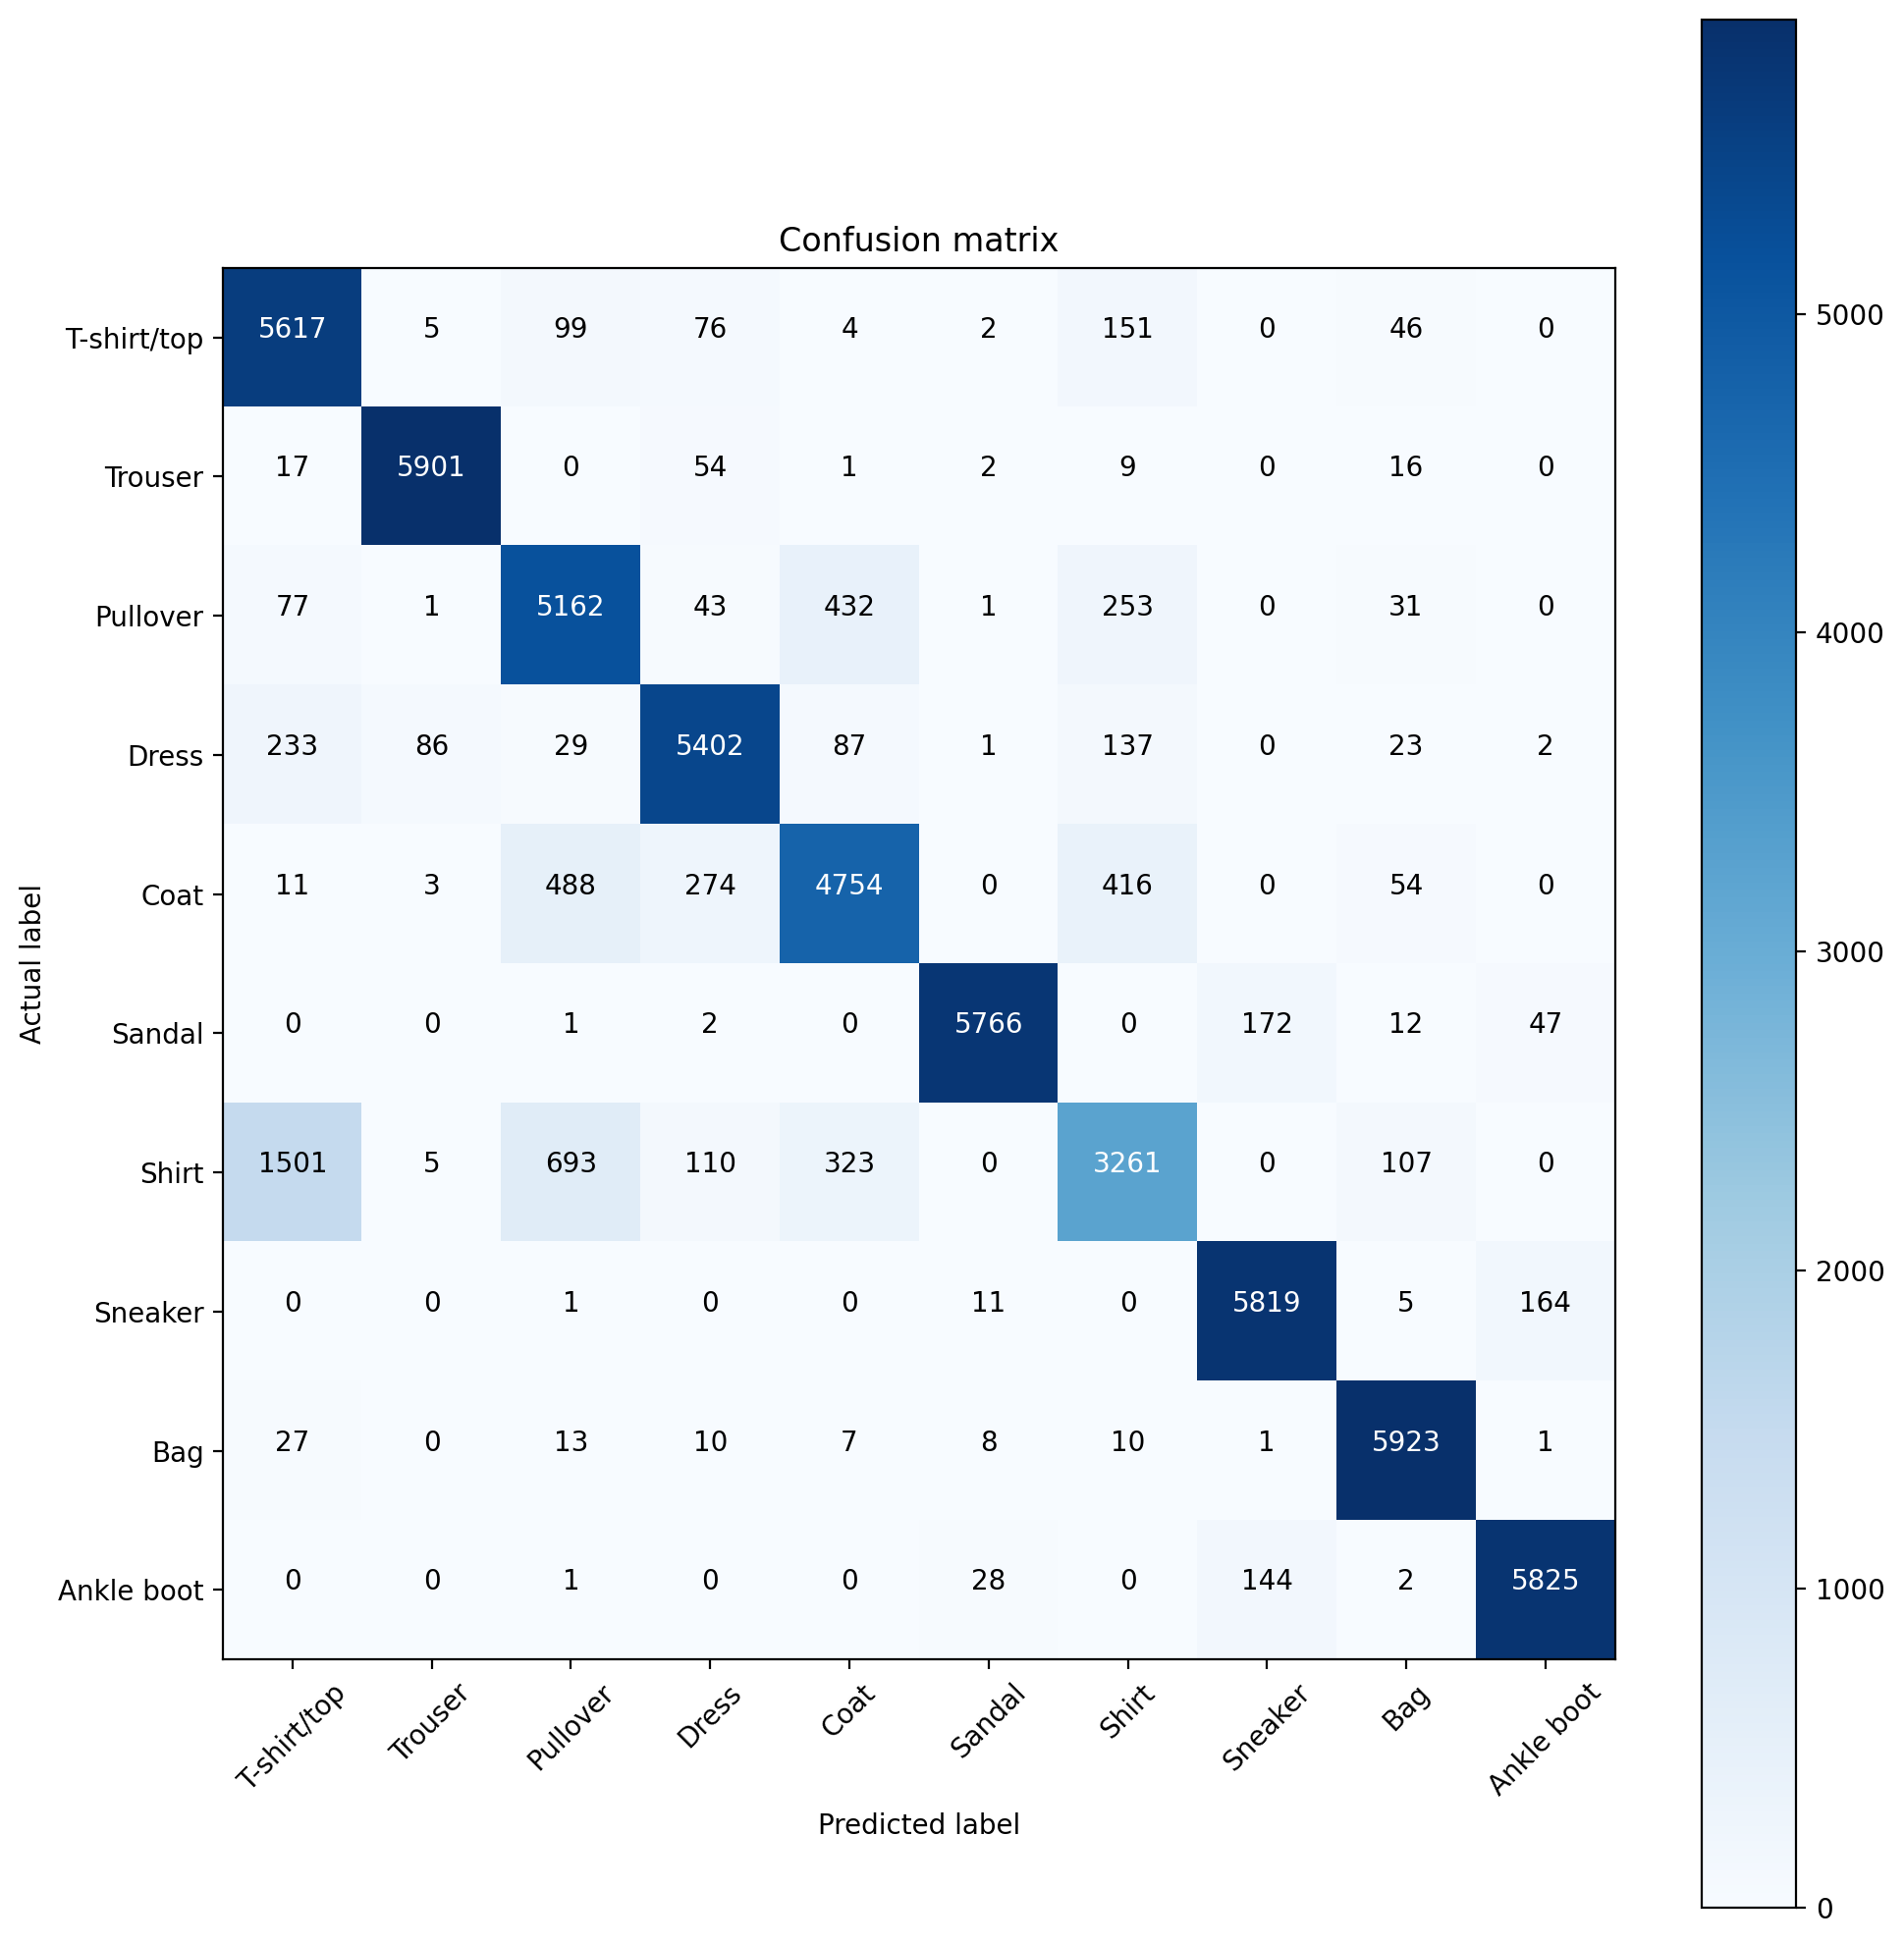

In [20]:
plt.figure(figsize=(10,10), dpi=200)
plot_confusion_matrix(cmt, names)

### 29 Stack vs Concat in PyTorch, Tensorflow & Numpy

In [21]:
import torch

In [23]:
t1 = torch.tensor([1,1,1])
t1, t1.shape

(tensor([1, 1, 1]), torch.Size([3]))

In [24]:
t1.unsqueeze(dim=0), t1.unsqueeze(dim=0).shape

(tensor([[1, 1, 1]]), torch.Size([1, 3]))

In [25]:
t1.unsqueeze(dim=1), t1.unsqueeze(dim=1).shape

(tensor([[1],
         [1],
         [1]]),
 torch.Size([3, 1]))

In [26]:
print(t1.shape)
print(t1.unsqueeze(dim=0).shape)
print(t1.unsqueeze(dim=1).shape)

torch.Size([3])
torch.Size([1, 3])
torch.Size([3, 1])


#### PyTorch: Stack vs Cat

In [27]:
import torch

In [28]:
t1 = torch.tensor([1,1,1])
t2 = torch.tensor([2,2,2])
t3 = torch.tensor([3,3,3])

In [29]:
torch.cat(
    (t1, t2, t3)
    , dim=0
)

tensor([1, 1, 1, 2, 2, 2, 3, 3, 3])

In [30]:
torch.stack(
    (t1, t2, t3)
    , dim=0
)

tensor([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]])

In [31]:
torch.cat(
    (
       t1.unsqueeze(dim=0)
     , t2.unsqueeze(dim=0)
     , t3.unsqueeze(dim=0))
    , dim=0
)

tensor([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]])

In [32]:
torch.stack(
    (t1, t2, t3)
    , dim=1
)

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [33]:
torch.cat(
    (
       t1.unsqueeze(dim=1)
     , t2.unsqueeze(dim=1)
     , t3.unsqueeze(dim=1))
    , dim=1
)

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

#### TensorFlow: Stack vs Concat

In [35]:
import tensorflow as tf

2024-11-28 14:41:35.266902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732776095.283243 3566308 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732776095.288368 3566308 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 14:41:35.305451: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
t1 = tf.constant([1,1,1])
t2 = tf.constant([2,2,2])
t3 = tf.constant([3,3,3])

2024-11-28 14:41:38.488064: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [37]:
tf.concat(
    (t1, t2, t3)
    , axis=0
)

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([1, 1, 1, 2, 2, 2, 3, 3, 3], dtype=int32)>

In [38]:
tf.stack(
    (t1, t2, t3)
    , axis=0
)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]], dtype=int32)>

In [40]:
tf.concat(
    (
        tf.expand_dims(t1, axis=0)
      , tf.expand_dims(t2, axis=0)
      , tf.expand_dims(t3, axis=0)
    )
    , axis=0
)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]], dtype=int32)>

In [41]:
tf.stack(
    (t1, t2, t3)
    , axis=1
)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]], dtype=int32)>

In [42]:
tf.concat(
    (
        tf.expand_dims(t1, axis=1)
      , tf.expand_dims(t2, axis=1)
      , tf.expand_dims(t3, axis=1)
    )
    , axis=1
)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]], dtype=int32)>

#### Numpy: Stack vs Concatenate

In [43]:
import numpy as np

In [44]:
t1 = np.array([1,1,1])
t2 = np.array([2,2,2])
t3 = np.array([3,3,3])

In [45]:
np.concatenate(
    (t1, t2, t3)
    , axis=0
)

array([1, 1, 1, 2, 2, 2, 3, 3, 3])

In [46]:
np.stack(
    (t1, t2, t3)
    , axis=0
)

array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]])

In [47]:
np.concatenate(
    (
        np.expand_dims(t1, axis=0)
      , np.expand_dims(t2, axis=0)
      , np.expand_dims(t3, axis=0)
    )
    , axis=0
)

array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]])

In [48]:
np.stack(
    (t1, t2, t3)
    , axis=1
)

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

In [49]:
np.concatenate(
    (
        np.expand_dims(t1, axis=1)
      , np.expand_dims(t2, axis=1)
      , np.expand_dims(t3, axis=1)
    )
    , axis=1
)

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

In [50]:
??np.stack

Signature:       np.stack(arrays, axis=0, out=None, *, dtype=None, casting='same_kind')
Call signature:  np.stack(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function stack at 0x7a949d7813a0>
File:            ~/miniconda3/envs/py312/lib/python3.12/site-packages/numpy/core/shape_base.py
Source:         
@array_function_dispatch(_stack_dispatcher)
def stack(arrays, axis=0, out=None, *, dtype=None, casting="same_kind"):
    """
    Join a sequence of arrays along a new axis.

    The ``axis`` parameter specifies the index of the new axis in the
    dimensions of the result. For example, if ``axis=0`` it will be the first
    dimension and if ``axis=-1`` it will be the last dimension.

    .. versionadded:: 1.10.0

    Parameters
    ----------
    arrays : sequence of array_like
        Each array must have the same shape.

    axis : int, optional
        The axis in the result array along which the input arrays are stacked.

    out : ndarray, optional
 

### 30 TensorBoard with PyTorch - Visualize Deep Learning Metrics

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transform

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

from torch.utils.tensorboard import SummaryWriter # <-- new

print(torch.__version__)
print(torchvision.__version__)

class Network(nn.Module):
    def __init__(self, channels=1): # default grayscale
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=6, kernel_size=5) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120) # ((28-5+1)/2 -5 +1)/2 = 4
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, (2, 2), stride=2)

        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, (2, 2), stride=2)

        t = t.reshape(-1, 12*4*4)
        t = F.relu(self.fc1(t))

        t = F.relu(self.fc2(t))

        t = self.out(t)
        
        return t
    
def get_num_correct(preds, labels):
    return (preds.argmax(dim=1) == labels).sum().item()

2.5.1+cu124
0.20.1+cu124


In [53]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    download=True,
    transform=transform.Compose([
        transform.ToTensor()
    ]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True) 


#### Starting out with TensorBaord (Network Graph and Images)

In [54]:


tb = SummaryWriter()
network = Network()

images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)

tb.add_image('images', grid)
tb.add_graph(network, images)

tb.close()


In [55]:
# !tensorboard --logdir=runs

#### The Training Loop Review

In [56]:
network = Network()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

for epoch in range(1):    
    total_loss = 0
    total_correct = 0
    
    for batch in train_loader:    
        images, labels = batch 
        preds = network(images)
        loss = F.cross_entropy(preds, labels) # check that loss tensor has a gradient attribute
                                              # so that line 17 makes sense
        optimizer.zero_grad() # set all gradients to zero
        loss.backward() # calculate gradient
        optimizer.step() # update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )


epoch 0 total_correct: 47456 loss: 332.39002445340157


In [60]:
network = Network()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)

tb = SummaryWriter()
tb.add_image('images', grid)
tb.add_graph(network, images)


for epoch in range(10):    
    total_loss = 0
    total_correct = 0
    
    for batch in train_loader:    
        images, labels = batch 
        preds = network(images)
        loss = F.cross_entropy(preds, labels) 
                                              #
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step() 
        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    tb.add_scalar('Loss', total_loss, epoch)
    tb.add_scalar('Number Correct', total_correct, epoch)
    tb.add_scalar('Accuracy', total_correct / len(train_loader), epoch)

    tb.add_histogram('conv1.bias', network.conv1.bias, epoch)
    tb.add_histogram('conv1.weight', network.conv1.weight, epoch)
    tb.add_histogram('conv1.weight.grad', network.conv1.weight.grad, epoch)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

tb.close()

epoch 0 total_correct: 47270 loss: 336.2039997279644
epoch 1 total_correct: 51483 loss: 231.3052719682455
epoch 2 total_correct: 52164 loss: 209.95938220620155
epoch 3 total_correct: 52667 loss: 198.88148514926434
epoch 4 total_correct: 52945 loss: 191.13619865477085
epoch 5 total_correct: 53044 loss: 188.17342147231102
epoch 6 total_correct: 53168 loss: 184.6170008033514
epoch 7 total_correct: 53261 loss: 183.37351854890585
epoch 8 total_correct: 53535 loss: 177.67099650204182
epoch 9 total_correct: 53516 loss: 175.72535314410925


### 31 Hyperparameter Tuning and Experimenting

In [61]:
for name, weight in network.named_parameters():
    print(name, weight.shape)

conv1.weight torch.Size([6, 1, 5, 5])
conv1.bias torch.Size([6])
conv2.weight torch.Size([12, 6, 5, 5])
conv2.bias torch.Size([12])
fc1.weight torch.Size([120, 192])
fc1.bias torch.Size([120])
fc2.weight torch.Size([60, 120])
fc2.bias torch.Size([60])
out.weight torch.Size([10, 60])
out.bias torch.Size([10])


In [62]:
for name, weight in network.named_parameters():
    print(f'{name}.grad', weight.grad.shape)

conv1.weight.grad torch.Size([6, 1, 5, 5])
conv1.bias.grad torch.Size([6])
conv2.weight.grad torch.Size([12, 6, 5, 5])
conv2.bias.grad torch.Size([12])
fc1.weight.grad torch.Size([120, 192])
fc1.bias.grad torch.Size([120])
fc2.weight.grad torch.Size([60, 120])
fc2.bias.grad torch.Size([60])
out.weight.grad torch.Size([10, 60])
out.bias.grad torch.Size([10])


In [ ]:
batch_size = 100
lr = 0.01

network = Network()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)

comment = f' batch_size={batch_size} lr={lr}'
tb = SummaryWriter(comment=comment)
tb.add_image('images', grid)
tb.add_graph(network, images)


for epoch in range(10):    
    total_loss = 0
    total_correct = 0
    
    for batch in train_loader:    
        images, labels = batch 
        preds = network(images)
        loss = F.cross_entropy(preds, labels) 
                                              #
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step() 
        total_loss += loss.item() * batch_size
        total_correct += get_num_correct(preds, labels)

    tb.add_scalar('Loss', total_loss, epoch)
    tb.add_scalar('Number Correct', total_correct, epoch)
    tb.add_scalar('Accuracy', total_correct / len(train_loader), epoch)

    # tb.add_histogram('conv1.bias', network.conv1.bias, epoch)
    # tb.add_histogram('conv1.weight', network.conv1.weight, epoch)
    # tb.add_histogram('conv1.weight.grad', network.conv1.weight.grad, epoch)
    for name, weight in network.named_parameters():
        tb.add_histogram(name, weight, epoch)
        tb.add_histogram(f'{name}.grad', weight.grad, epoch)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

tb.close()

#### Parameter Lists

In [64]:
# batch_size_list = [10, 100, 1000, 10000]
# lr_list = [0.01, 0.001, 0.0001]

parameters = dict(
    lr = [0.01, 0.001]
    , batch_size = [10, 100, 1000]
    , shuffle = [True, False]
)

In [66]:
from itertools import product

param_values = [v for v in parameters.values()]
param_values

[[0.01, 0.001], [10, 100, 1000], [True, False]]

In [69]:
for batch_size, lr, shuffle in product(*param_values):
    comment = f' batch_size={batch_size} lr={lr} shuffle={shuffle}'
    print(comment)

    # Training process given the set of parameters

 batch_size=0.01 lr=10 shuffle=True
 batch_size=0.01 lr=10 shuffle=False
 batch_size=0.01 lr=100 shuffle=True
 batch_size=0.01 lr=100 shuffle=False
 batch_size=0.01 lr=1000 shuffle=True
 batch_size=0.01 lr=1000 shuffle=False
 batch_size=0.001 lr=10 shuffle=True
 batch_size=0.001 lr=10 shuffle=False
 batch_size=0.001 lr=100 shuffle=True
 batch_size=0.001 lr=100 shuffle=False
 batch_size=0.001 lr=1000 shuffle=True
 batch_size=0.001 lr=1000 shuffle=False
